# EOSC 213 — Lecture 4
## Forward Euler Method for Initial Value Problems (IVPs)

**Goal:** Implement the **Forward Euler** method in **PyTorch** and apply it to:

1. Exponential decay (has an analytic solution)  
2. Logistic growth (has an analytic solution)  
3. A forced nonlinear/oscillatory ODE **without a simple closed form** (we still can solve it numerically)

Along the way we will:
- build a reusable `forward_euler(...)` function
- compare numerical vs analytic solutions when available
- see how the step size `h` changes accuracy (and sometimes stability)


In [2]:
import torch
import matplotlib.pyplot as plt

## (1) The problem we want to solve

We consider an **initial value problem (IVP)**:

$\frac{dx}{dt} = f(t, x), \qquad x(t_0) = x_0.$

On a computer we use a time grid:

$t_0,\; t_1=t_0+h,\; t_2=t_0+2h,\; \dots,\; t_N=t_0+Nh,$

and we approximate the solution by values $x_j \approx x(t_j)$.


## (2) Forward Euler update rule

Using a forward difference approximation:

$x'(t_j) \approx \frac{x(t_{j+1}) - x(t_j)}{h},$

and setting $x'(t_j)=f(t_j,x(t_j))$, we get:


$x_{j+1} = x_j + h\, f(t_j, x_j).$

That’s the entire method: start at $x_0$ and keep stepping forward.


In [3]:
def forward_euler(f, t0, x0, h, N):
    # Make x0 a tensor
    x0 = torch.as_tensor(x0, dtype=torch.float32)

    # Time grid: [t0, t0 + h, t0 + 2h, ..., t0 + Nh]
    t = t0 + h * torch.arange(N + 1, dtype=torch.float32)
    # Allocate solution array
    x = torch.zeros((N + 1,) + x0.shape, dtype=torch.float32)
    x[0] = x0
    # Loop (time stepping)
    for j in range(N):
        x[j + 1] = x[j] + h * f(t[j], x[j])

    return t, x


In [1]:
def forward_euler(f, t0, x0, h, N):
    """Forward Euler for x' = f(t, x), x(t0)=x0.

    Args:
        f: callable (t, x) -> dx/dt (same shape as x)
        t0: float (start time)
        x0: torch tensor or float (initial state)
        h: float (time step)
        N: int (number of steps)

    Returns:
        t: (N+1,) tensor of times
        x: (N+1, ...) tensor of states
    """
    # Make x0 a tensor
    x0 = torch.as_tensor(x0, dtype=torch.float32)

    # Time grid
    # [t0, t0 + h, t0 + 2h, ..., t0 + Nh]
    t = t0 + h * torch.arange(N + 1, dtype=torch.float32)

    # Allocate solution array
    x = torch.zeros((N + 1,) + x0.shape, dtype=torch.float32)
    x[0] = x0

    # Loop (time stepping)
    for j in range(N):
        x[j + 1] = x[j] + h * f(t[j], x[j])

    return t, x


### Quick sanity check (toy ODE)

Solve $x' = 1$ with $x(0)=0$.  
Exact solution is $x(t)=t$.


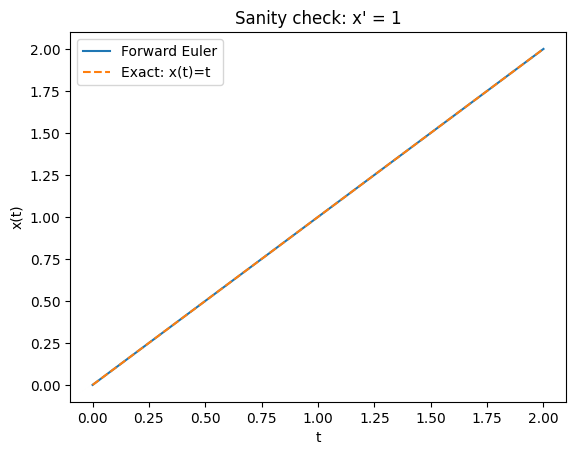

In [4]:
f_const = lambda t, x: torch.tensor(1.0)

t, x = forward_euler(f_const, t0=0.0, x0=0.0, h=0.1, N=20)

plt.figure()
plt.plot(t, x, label="Forward Euler")
plt.plot(t, t, '--', label="Exact: x(t)=t")
plt.xlabel("t")
plt.ylabel("x(t)")
plt.legend()
plt.title("Sanity check: x' = 1")
plt.show()


# Example 1 — Exponential decay

Model:

$\frac{dx}{dt} = -\lambda x, \qquad \lambda>0$

Exact solution:

$x(t) = x_0 e^{-\lambda t}$


In [5]:
def exp_decay_rhs(lmbda):
    return lambda t, x: -lmbda * x

def exp_decay_exact(t, x0, lmbda):
    return x0 * torch.exp(-lmbda * t)


## Compare numerical vs analytic for different step sizes

We will:
- keep $\lambda$ and $x_0$ fixed
- solve on $[0, T]$
- try multiple step sizes $h$


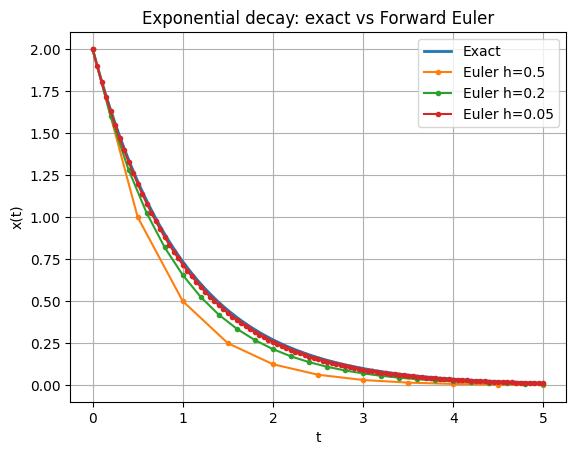

In [8]:
lmbda = 1.0
x0 = 2.0
T = 5.0

hs = [0.5, 0.2, 0.05]  # coarse -> fine

plt.figure()
t_fine = torch.linspace(0.0, T, 2000)
x_exact = exp_decay_exact(t_fine, x0, lmbda)
plt.plot(t_fine, x_exact, label="Exact", linewidth=2)

for h in hs:
    N = int(T / h)
    t, x = forward_euler(exp_decay_rhs(lmbda), t0=0.0, x0=x0, h=h, N=N)
    plt.plot(t, x, marker="o", markersize=3, label=f"Euler h={h}")

plt.xlabel("t")
plt.ylabel("x(t)")
plt.title("Exponential decay: exact vs Forward Euler")
plt.legend()
plt.grid(True)
plt.show()

## Error at final time

A simple (but useful) accuracy check: compare the final value $x(T)$.


In [9]:
for h in hs:
    N = int(T / h)
    t, x = forward_euler(exp_decay_rhs(lmbda), t0=0.0, x0=x0, h=h, N=N)
    xT_num = x[-1]
    xT_exact = exp_decay_exact(torch.tensor(T), x0, lmbda)
    err = torch.abs(xT_num - xT_exact)
    print(f"h={h:<5}  x(T) num={xT_num.item():.6f}  exact={xT_exact.item():.6f}  |error|={err.item():.6e}")


h=0.5    x(T) num=0.001953  exact=0.013476  |error|=1.152277e-02
h=0.2    x(T) num=0.007556  exact=0.013476  |error|=5.920107e-03
h=0.05   x(T) num=0.011841  exact=0.013476  |error|=1.634835e-03


### (Optional intuition) What is Forward Euler doing here?

For exponential decay,

$x_{j+1} = (1-\lambda h) x_j$
so each step multiplies by the factor $(1-\lambda h)$.

If $h$ is too large, that factor can be negative, causing oscillations (a sign of instability).
We’ll talk more about **stability** soon.


# Example 2 — Logistic growth

Model:

$\frac{dx}{dt} = r x\left(1-\frac{x}{K}\right), \qquad r>0,\;K>0.$

Exact solution:

$x(t)=\frac{K}{1+\left(\frac{K-x_0}{x_0}\right)e^{-rt}}.$


In [11]:
def logistic_rhs(r, K):
    return lambda t, x: r * x * (1.0 - x / K)

def logistic_exact(t, x0, r, K):
    return K / (1.0 + ((K - x0) / x0) * torch.exp(-r * t))


## Compare numerical vs analytic (logistic)

We’ll solve on \([0,T]\) and compare Euler with the exact curve.


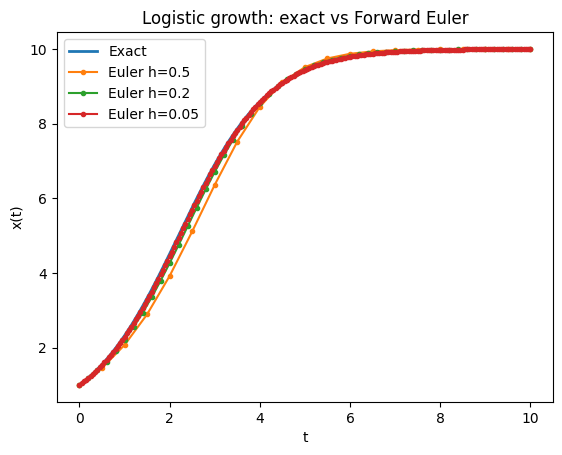

In [12]:
r = 1.0
K = 10.0
x0 = 1.0
T = 10.0

hs = [0.5, 0.2, 0.05]

plt.figure()
t_fine = torch.linspace(0.0, T, 2000)
x_exact = logistic_exact(t_fine, x0, r, K)
plt.plot(t_fine, x_exact, label="Exact", linewidth=2)

for h in hs:
    N = int(T / h)
    t, x = forward_euler(logistic_rhs(r, K), t0=0.0, x0=x0, h=h, N=N)
    plt.plot(t, x, marker="o", markersize=3, label=f"Euler h={h}")

plt.xlabel("t")
plt.ylabel("x(t)")
plt.title("Logistic growth: exact vs Forward Euler")
plt.legend()
plt.show()


## Parameter experiments (r and K)

A nice way to build intuition is to hold one parameter fixed while varying the other.


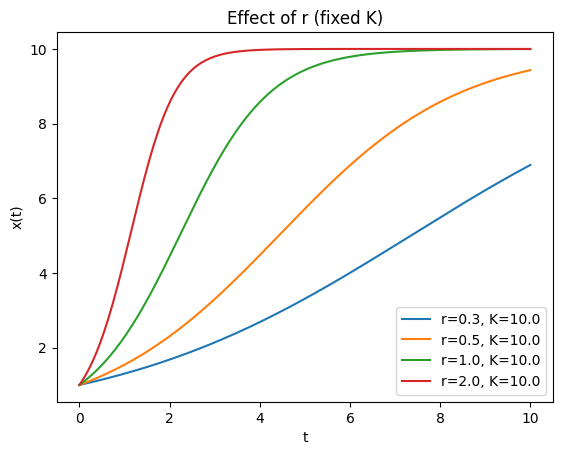

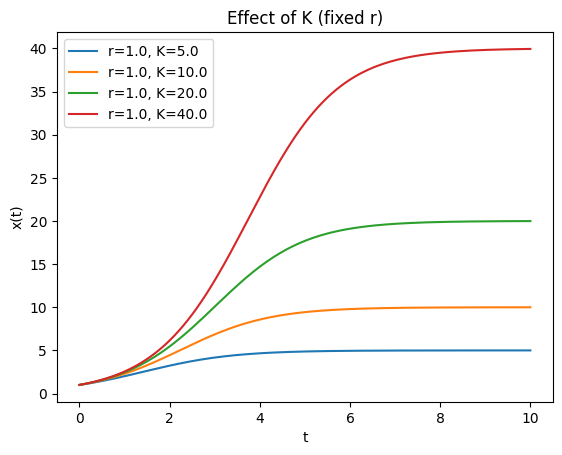

In [13]:
t_end = 10.0
h = 0.05
N = int(t_end / h)
x0 = 1.0

# Plot 1: vary r, fixed K
K_fixed = 10.0
rs = [0.3, 0.5, 1.0, 2.0]

plt.figure()
for r in rs:
    t, x = forward_euler(logistic_rhs(r, K_fixed), 0.0, x0, h, N)
    plt.plot(t, x, label=f"r={r}, K={K_fixed}")

plt.xlabel("t")
plt.ylabel("x(t)")
plt.title("Effect of r (fixed K)")
plt.legend()
plt.show()

# Plot 2: vary K, fixed r
r_fixed = 1.0
Ks = [5.0, 10.0, 20.0, 40.0]

plt.figure()
for K in Ks:
    t, x = forward_euler(logistic_rhs(r_fixed, K), 0.0, x0, h, N)
    plt.plot(t, x, label=f"r={r_fixed}, K={K}")

plt.xlabel("t")
plt.ylabel("x(t)")
plt.title("Effect of K (fixed r)")
plt.legend()
plt.show()


# Example 3 — A forced ODE with no simple closed form

Consider:

$\frac{dx}{dt} = -x + \sin(t^2), \qquad x(0)=x_0$

This is a **linear** ODE, and you can write a solution using an **integral** (integrating factor),
but there is **no simple elementary closed-form expression** because $\sin(t^2)$ leads to Fresnel-type integrals.

So: **numerics are the practical tool.**


In [15]:
def forced_rhs(t, x):
    return -x + torch.sin(t**2)


## Solve with Forward Euler and visualize

We’ll try multiple step sizes and see how the curves change.


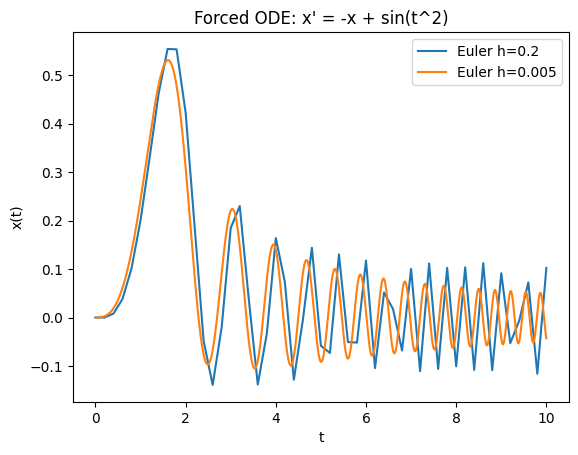

In [16]:
x0 = 0.0
T = 10.0
hs = [0.2, 0.005]  # show a coarse and a finer one

plt.figure()
for h in hs:
    N = int(T / h)
    t, x = forward_euler(forced_rhs, 0.0, x0, h, N)
    plt.plot(t, x, label=f"Euler h={h}")

plt.xlabel("t")
plt.ylabel("x(t)")
plt.title("Forced ODE: x' = -x + sin(t^2)")
plt.legend()
plt.show()


## Step-size study (basic)

We don’t have an analytic solution to compare to easily.  
A common trick: treat a very small step size as a **reference** solution.


In [17]:
# Reference (very small step)
h_ref = 0.005
N_ref = int(T / h_ref)
t_ref, x_ref = forward_euler(forced_rhs, 0.0, x0, h_ref, N_ref)

def sample_reference_at_times(t_query, t_ref, x_ref):
    """Simple nearest-neighbor sampling of a reference solution."""
    idx = torch.clamp(torch.round(t_query / (t_ref[1]-t_ref[0])).long(), 0, len(t_ref)-1)
    return x_ref[idx]

for h in [0.2, 0.1, 0.05]:
    N = int(T / h)
    t, x = forward_euler(forced_rhs, 0.0, x0, h, N)
    x_ref_on_grid = sample_reference_at_times(t, t_ref, x_ref)
    err = torch.max(torch.abs(x - x_ref_on_grid))
    print(f"h={h:<5}  max |x - x_ref| over grid ≈ {err.item():.6e}")


h=0.2    max |x - x_ref| over grid ≈ 1.453230e-01
h=0.1    max |x - x_ref| over grid ≈ 5.326591e-02
h=0.05   max |x - x_ref| over grid ≈ 2.490762e-02


## Summary: What you should be comfortable with after Lecture 2

After this notebook, you should be comfortable with:
- Turning an IVP into a time grid $t_0,\dots,t_N$
- Implementing Forward Euler: $x_{j+1}=x_j+h f(t_j,x_j)$
- Comparing against analytic solutions when they exist
- Using step-size experiments to reason about accuracy
